## Trial simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import binom
import pandas as pd
from itertools import accumulate

## Full elaborated simulation

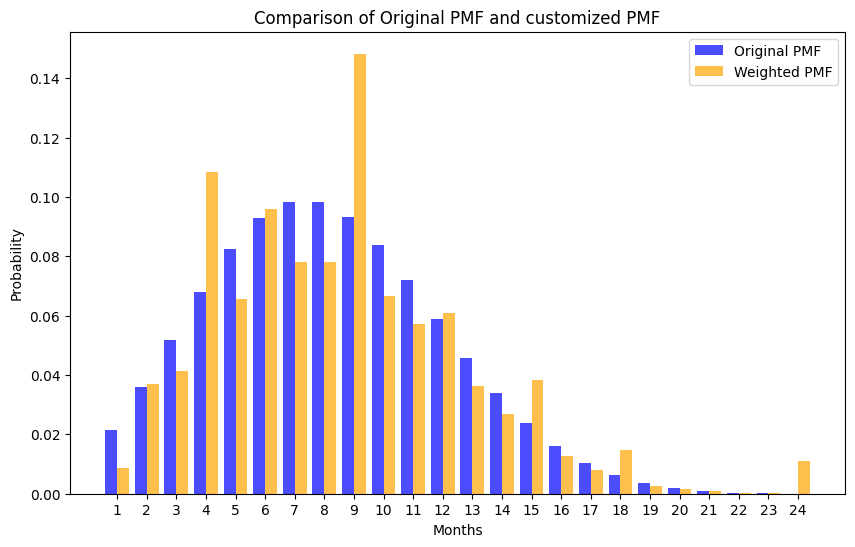

In [2]:
number_of_months = 24
x = np.arange(1, number_of_months + 1)
pmf = binom.pmf(x, number_of_months, 0.32)
pmf = pmf**0.3/(pmf**0.3).sum()

# Define weights based on examination
weights = np.ones_like(pmf)
weights_ultrasound = np.zeros_like(pmf)
weights_PET = np.zeros_like(pmf)

weights_ultrasound[[1,5,11,14,17,20]] = 0.3
weights_PET[[3,8,23]] = 1

#some extra customization
weights += weights_ultrasound + weights_PET
weights[-1] = 300
weights[14] = 2
weights[17] = 3
weights[0] = 0.5

# Apply weights to the PMF
weighted_pmf = pmf * weights

# Normalize the weighted PMF
weighted_pmf /= np.sum(weighted_pmf)

# Plot the original PMF and weighted PMF
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, pmf, width=0.4, label='Original PMF', color='blue', alpha=0.7)
plt.bar(x + 0.2, weighted_pmf, width=0.4, label='Weighted PMF', color='orange', alpha=0.7)
plt.xlabel('Months')
plt.ylabel('Probability')
plt.xticks(x)
plt.title('Comparison of Original PMF and customized PMF')
plt.legend()
plt.show()

In [3]:
print('probability of diagnosis in months 1-4:', np.sum(weighted_pmf[:4])*100,'%')
print('probability of diagnosis in months 5-12:', np.sum(weighted_pmf[4:12])*100,'%')
print('probability of diagnosis in months 12-24:', np.sum(weighted_pmf[12:])*100,'%')
print('probability of being diagnosed until month 9:', np.sum(weighted_pmf[:9])*100, '%')


probability of diagnosis in months 1-4: 19.531632983823975 %
probability of diagnosis in months 5-12: 65.09309184474948 %
probability of diagnosis in months 12-24: 15.375275171426539 %
probability of being diagnosed until month 9: 66.14391019159353 %


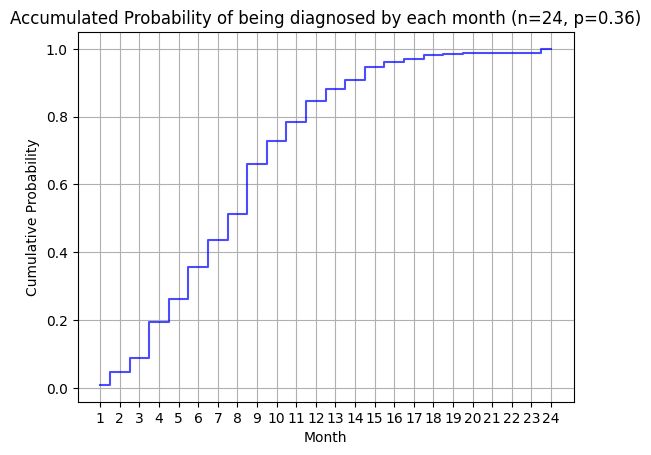

In [4]:
cdf = list(accumulate(weighted_pmf))
plt.step(x, cdf, where='mid', color='blue', alpha=0.7)
plt.title('Accumulated Probability of being diagnosed by each month (n=24, p=0.36)')
plt.xlabel('Month')
plt.ylabel('Cumulative Probability')
plt.xticks(x);
plt.grid(True)

## Standard analyzer with fixed interim analysis and "whole" patient analysis

In [5]:
def interim_evaluator(recruitement_list,patient_true_status,patient_actual_status,p_interim = 0.10):
    upper_limit_under_p = binom.ppf(0.95, recruitement_list.sum(), p_interim)
    stopp_trial_true = 1 if sum(patient_true_status) >= upper_limit_under_p else 0
    stopp_trial_observed = 1 if sum(patient_actual_status) >= upper_limit_under_p else 0
    # print((recruitement_list).sum())
    # print('events true', sum(patient_true_status))
    # print('stopping condition', upper_limit_under_p)
    return np.array([stopp_trial_true, stopp_trial_observed])
def rate_sampler(month):
    rate_change = [5,9,13,17]
    rate_index = 4 - (np.array(rate_change) > month).sum()
    if rate_index == 0:
        sample = np.round(np.random.normal(2,2/3,1))
        sample = np.clip(sample,0,4)
    elif rate_index == 1:
        sample = np.round(np.random.normal(3,2/3,1))
        sample = np.clip(sample,0,7)
    elif rate_index == 2:
        sample = np.round(np.random.normal(5,4/6,1))
        sample = np.clip(sample,0,8)
    elif rate_index == 3:
        sample = np.round(np.random.normal(6, 4/6, 1))
        sample = np.clip(sample, 0, 8)
    elif rate_index >= 4:
        sample = np.round(np.random.normal(7, 4/6, 1))
        sample = np.clip(sample, 0, 10)
    return sample

def sample_custom_pmf(size=1):
    x = np.arange(1, 24 + 1)
    pmf = binom.pmf(x, 24, 0.32)
    pmf = pmf**0.3/(pmf**0.3).sum()

    # Define weights based on examination
    weights = np.ones_like(pmf)
    weights_ultrasound = np.zeros_like(pmf)
    weights_PET = np.zeros_like(pmf)

    weights_ultrasound[[1,5,11,14,17,20]] = 0.3
    weights_PET[[3,8,23]] = 1

    #some extra customization
    weights += weights_ultrasound + weights_PET
    weights[-1] = 300
    weights[14] = 2
    weights[17] = 3
    weights[0] = 0.5

    # Apply weights to the PMF
    weighted_pmf = pmf * weights

    # Normalize the weighted PMF
    weighted_pmf /= np.sum(weighted_pmf)
    cdf = list(accumulate(weighted_pmf))
    return np.searchsorted(cdf, np.random.rand(size))+1

def recruitement_evaluator_extended(running_months = 30, recruitement_condition = None, total_number_pat = 120, p0 = 0.1, interim = None, p_interim = 0.10):
    if recruitement_condition > total_number_pat:
        print('recruitement_condition must be lower or equal to total_number_pat. condition has been set to total_number_pat')
        recruitement_condition = total_number_pat
    if interim != None:
        interim_analyses = np.zeros((len(interim),2))
    else: 
        interim_analyses = 0
    interim_looper = 0
    number_of_follow_up_months = 24
    recruitement_list = np.zeros((total_number_pat,1))
    patients_time_count = np.zeros((total_number_pat,1))
    patient_true_status = np.zeros((total_number_pat,1))
    patient_observed_status = np.zeros((total_number_pat,1))
    recessive_patients_diagnose_time = np.zeros((total_number_pat,1))
    recruitement_month = np.zeros((total_number_pat,1))
    patient_index = 0 #index of actual patient to be recruited
    rate_index = 0 #index of which rate is being used of the rate
    x = np.arange(0, number_of_follow_up_months + 1)
    #loop for recruiting a certain number of months
    if recruitement_condition == None:
        for month in range(1,running_months + 1):
            # update the already recruited patients
            patients_time_count[:patient_index] += 1
            for recruited_patient_index in range(0,total_number_pat):
                #update the observed status of the patients
                if patient_true_status[recruited_patient_index] == 1 and recessive_patients_diagnose_time[recruited_patient_index] == patients_time_count[recruited_patient_index]:
                    patient_observed_status[recruited_patient_index] = 1
            #sample the number of recruited patients
            if patient_index < total_number_pat - 1:
                number_of_new_patients = int(rate_sampler(month)[0])
                if number_of_new_patients > (total_number_pat - 1)-patient_index:
                    number_of_new_patients = (total_number_pat)-patient_index                
                for k in range(0,number_of_new_patients):
                    patient_true_status[patient_index] = 0 if random.uniform(0,1) > p0 else 1
                    recruitement_list[patient_index] = 1
                    recruitement_month[patient_index] = month
                    if patient_true_status[patient_index] == 1:
                        recessive_patients_diagnose_time[patient_index] = int(sample_custom_pmf(size = 1)[0])
                    patient_index += 1
            if (interim != None) and (recruitement_list.sum() >= interim[interim_looper]):
                interim_analyses[interim_looper] = interim_evaluator(recruitement_list[:interim[interim_looper]],patient_true_status[:interim[interim_looper]],patient_observed_status[:interim[interim_looper]],p_interim)
                if interim_looper < len(interim)-1:
                    interim_looper += 1
   
    #loop for recruiting for a certain amount of patients
    else:
        month = 1
        while patient_index < recruitement_condition:
            # update the already recruited patients
            patients_time_count[:patient_index] += 1
            for recruited_patient_index in range(0,patient_index):
                #update the observed status of the patients
                if patient_true_status[recruited_patient_index] == 1:
                    if recessive_patients_diagnose_time[recruited_patient_index] == patients_time_count[recruited_patient_index]:
                        patient_observed_status[recruited_patient_index] = 1
            # recruite new patients
            if patient_index < total_number_pat:
                number_of_new_patients = int(rate_sampler(month)[0])
                if number_of_new_patients > (recruitement_condition)-patient_index:
                    number_of_new_patients = (recruitement_condition)-patient_index
                for k in range(0,number_of_new_patients):
                    patient_true_status[patient_index] = 0 if random.uniform(0,1) > p0 else 1
                    recruitement_list[patient_index] = 1
                    recruitement_month[patient_index] = month
                    if patient_true_status[patient_index] == 1:
                        recessive_patients_diagnose_time[patient_index] = int(sample_custom_pmf(size = 1)[0])
                    patient_index += 1 
            if (interim != None) and (recruitement_list.sum() >= interim[interim_looper]):
                interim_analyses[interim_looper] = interim_evaluator(recruitement_list[:interim[interim_looper]],patient_true_status[:interim[interim_looper]],patient_observed_status[:interim[interim_looper]],p_interim)
                interim_looper += 1     
            month += 1     

    concatenated_data = np.concatenate((recruitement_list,recruitement_month, patients_time_count,patient_true_status, patient_observed_status, recessive_patients_diagnose_time), axis=1)
    df = pd.DataFrame(concatenated_data, columns=['Recruitement status','Month of recruitement', 'Months since recruitement', 'True recessive status', 'Observed status', 'diagnose time after treatment'])
    return df, month, interim_analyses


In [6]:
df, month, interim_analyses = recruitement_evaluator_extended(running_months=30, recruitement_condition= 120, total_number_pat = 120, p0 = 0.1,interim=[15,28,35,42,49,57,72,87,95,120])
month

25

In [7]:
interim_analyses

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [8]:
interim_analyses[:len([15,28,35,42,49,57,72,87,95,120])-1]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [9]:
number_of_simulations = 10000
stopping_array2 = np.zeros((number_of_simulations,2))
stopping_at_interim2 = np.zeros((number_of_simulations,2))
stopping_at_end2 = np.zeros((number_of_simulations,2))
# interim = [15,28,35,42,49,57,72,87,95,120]
interim = [60,120]
p0 = 0.10

for i in range(0,number_of_simulations):
    df_looper, month_looper, interim_analyses_looper = interim_analyses = recruitement_evaluator_extended(recruitement_condition= 120, total_number_pat = 120, p0 = p0,interim=interim)
    stopping_array2[i] = np.any(interim_analyses_looper,axis = 0)
    stopping_at_interim2[i] = np.any(interim_analyses_looper[:len(interim)-1],axis = 0)
    stopping_at_end2[i] = interim_analyses_looper[-1]

In [10]:
print('stopping in total',stopping_array2.sum(axis = 0)/10000*100,'%')
print('stopping in at interim',stopping_at_interim2.sum(axis = 0)/10000*100,'%')
print('stopping after trial',stopping_at_end2.sum(axis = 0)[0]/10000*100,'%')

stopping in total [9.78 0.03] %
stopping in at interim [7.13 0.01] %
stopping after trial 5.34 %


Conclusion: In 10'000 attempts we would never pause the trial under H0

Conclusion 2: under 15% recessives we would pause the trial in 1.03% of cases

Conclusion 3: under 20% recessives, we would pause the trial in 11.25% of cases

## Trial with break and run out time
This one only makes sense to be used with a number of patients to be recruited

In [116]:
def interim_evaluator(recruitement_list,patients_time_count,patient_true_status,patient_observed_status, recessive_patients_diagnose_time,number_at_interim, p_interim = 0.10, run_at_interim = False):
    if run_at_interim != False:
        # update the already recruited patients
        patients_time_count += run_at_interim
        for recruited_patient_index in range(0,len(recruitement_list)):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                    patient_observed_status[recruited_patient_index] = 1
    # print(patient_observed_status.sum())
    # print(patient_true_status.sum())
    upper_limit_under_p = binom.ppf(0.95, recruitement_list.sum(), p_interim)
    stopp_trial_true = 1 if sum(patient_true_status) >= upper_limit_under_p else 0
    stopp_trial_observed = 1 if sum(patient_observed_status) >= upper_limit_under_p else 0
    # print((recruitement_list))
    # print('events true', sum(patient_true_status))
    # print('stopping condition', upper_limit_under_p)
    return np.array([stopp_trial_true, stopp_trial_observed])
def rate_sampler(month):
    rate_change = [5,9,13,17]
    rate_index = 4 - (np.array(rate_change) > month).sum()
    if rate_index == 0:
        sample = np.round(np.random.normal(2,2/3,1))
        sample = np.clip(sample,0,4)
    elif rate_index == 1:
        sample = np.round(np.random.normal(3,2/3,1))
        sample = np.clip(sample,0,7)
    elif rate_index == 2:
        sample = np.round(np.random.normal(5,4/6,1))
        sample = np.clip(sample,0,8)
    elif rate_index == 3:
        sample = np.round(np.random.normal(6, 4/6, 1))
        sample = np.clip(sample, 0, 8)
    elif rate_index >= 4:
        sample = np.round(np.random.normal(7, 4/6, 1))
        sample = np.clip(sample, 0, 10)
    return sample

def sample_custom_pmf(size=1):
    x = np.arange(1, 24 + 1)
    pmf = binom.pmf(x, 24, 0.32)
    pmf = pmf**0.3/(pmf**0.3).sum()

    # Define weights based on examination
    weights = np.ones_like(pmf)
    weights_ultrasound = np.zeros_like(pmf)
    weights_PET = np.zeros_like(pmf)

    weights_ultrasound[[1,5,11,14,17,20]] = 0.3
    weights_PET[[3,8,23]] = 1

    #some extra customization
    weights += weights_ultrasound + weights_PET
    weights[-1] = 300
    weights[14] = 2
    weights[17] = 3
    weights[0] = 0.5

    # Apply weights to the PMF
    weighted_pmf = pmf * weights

    # Normalize the weighted PMF
    weighted_pmf /= np.sum(weighted_pmf)
    cdf = list(accumulate(weighted_pmf))
    return np.searchsorted(cdf, np.random.rand(size))+1

def recruitement_evaluator_break(recruitement_condition = 120, total_number_pat = 120, p0 = 0.1, interim = None, p_interim = 0.10, run_at_interim = False, run_out = None):
    if recruitement_condition > total_number_pat:
        print('recruitement_condition must be lower or equal to total_number_pat. condition has been set to total_number_pat')
    if interim != None:
        interim_analyses = np.zeros((len(interim),2))
    else: 
        interim_analyses = 0
    interim_looper = 0
    number_of_follow_up_months = 24
    recruitement_list = np.zeros((total_number_pat,1))
    patients_time_count = np.zeros((total_number_pat,1))
    patient_true_status = np.zeros((total_number_pat,1))
    patient_observed_status = np.zeros((total_number_pat,1))
    recessive_patients_diagnose_time = np.zeros((total_number_pat,1))
    recruitement_month = np.zeros((total_number_pat,1))
    patient_index = 0 #index of actual patient to be recruited
    rate_index = 0 #index of which rate is being used of the rate
    x = np.arange(0, number_of_follow_up_months + 1)
    month = 1
    while patient_index < recruitement_condition:
        # update the already recruited patients
        patients_time_count[:patient_index] += 1
        for recruited_patient_index in range(0,patient_index):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                    patient_observed_status[recruited_patient_index] = 1
        # recruite new patients
        if patient_index < total_number_pat:
            number_of_new_patients = int(rate_sampler(month))
            if number_of_new_patients > (recruitement_condition)-patient_index:
                number_of_new_patients = (recruitement_condition)-patient_index
            for k in range(0,number_of_new_patients):
                patient_true_status[patient_index] = 0 if random.uniform(0,1) > p0 else 1
                recruitement_list[patient_index] = 1
                recruitement_month[patient_index] = month
                if patient_true_status[patient_index] == 1:
                    recessive_patients_diagnose_time[patient_index] = int(sample_custom_pmf(size = 1))
                patient_index += 1 
        if (interim != None) and (recruitement_list.sum() >= interim[interim_looper]):
            run_at_interim_looper = run_at_interim
            if run_out != None:
                run_at_interim_looper = run_at_interim if interim[interim_looper] != total_number_pat else run_out
            interim_analyses[interim_looper] = interim_evaluator(recruitement_list[:patient_index +1],patients_time_count[:patient_index+1].copy(),patient_true_status[:patient_index +1],patient_observed_status[:patient_index +1].copy(), recessive_patients_diagnose_time[:patient_index+1], number_at_interim = interim[interim_looper],p_interim = p_interim, run_at_interim= run_at_interim_looper)
            if run_at_interim != False:
                patients_time_count[:patient_index] += run_at_interim_looper
                month += run_at_interim_looper
                #update the observed status of the patients at the end
                for recruited_patient_index in range(0,patient_index):
                    if patient_true_status[recruited_patient_index] == 1:
                        if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                            patient_observed_status[recruited_patient_index] = 1

            interim_looper += 1     
        month += 1     

    concatenated_data = np.concatenate((recruitement_list,recruitement_month, patients_time_count,patient_true_status, patient_observed_status, recessive_patients_diagnose_time), axis=1)
    df = pd.DataFrame(concatenated_data, columns=['Recruitement status','Month of recruitement', 'Months since recruitement', 'True recessive status', 'Observed status', 'diagnose time after treatment'])
    return df, month, interim_analyses


In [117]:
df, month, interim_analyses = recruitement_evaluator_break(recruitement_condition= 120, total_number_pat = 120, p0 = 0.10, p_interim = 0.15,interim=[60,120], run_at_interim = 6, run_out = 0)
print(month)
interim_analyses

32


array([[0., 0.],
       [0., 0.]])

In [110]:
df

,Recruitement status,Month of recruitement,Months since recruitement,True recessive status,Observed status,diagnose time after treatment
0,1.0,1.0,28.0,1.0,1.0,12.0
1,1.0,1.0,28.0,0.0,0.0,0.0
2,1.0,2.0,27.0,0.0,0.0,0.0
3,1.0,2.0,27.0,0.0,0.0,0.0
4,1.0,2.0,27.0,0.0,0.0,0.0
...,...,...,...,...,...,...
115,1.0,29.0,0.0,0.0,0.0,0.0
116,1.0,29.0,0.0,0.0,0.0,0.0
117,1.0,29.0,0.0,0.0,0.0,0.0
118,1.0,29.0,0.0,0.0,0.0,0.0


In [154]:
number_of_simulations = 10000
stopping_array2 = np.zeros((number_of_simulations,2))
stopping_at_interim2 = np.zeros((number_of_simulations,2))
stopping_at_end2 = np.zeros((number_of_simulations,2))
interim = [60,120]
run_at_interim = 6
run_out = 0
p0 = 0.10
p_interim = 0.13

for i in range(0,number_of_simulations):
    df_looper, month_looper, interim_analyses_looper = interim_analyses =  recruitement_evaluator_break(recruitement_condition= 120, total_number_pat = 120, p0 = p0,p_interim = p_interim, interim=interim, run_at_interim = run_at_interim, run_out = run_out)
    stopping_array2[i] = np.any(interim_analyses_looper,axis = 0)
    stopping_at_interim2[i] = np.any(interim_analyses_looper[:len(interim)-1],axis = 0)
    stopping_at_end2[i] = interim_analyses_looper[-1]

In [156]:
print('stopping in total',stopping_array2.sum(axis = 0)/number_of_simulations*100,'%')
print('stopping in at interim',stopping_at_interim2.sum(axis = 0)/number_of_simulations*100,'%')
print('stopping after trial',stopping_at_end2.sum(axis = 0)[0]/number_of_simulations*100,'%')

stopping in total [1.3  0.02] %
stopping in at interim [1.07 0.02] %
stopping after trial 0.33 %


In [140]:
df_looper

,Recruitement status,Month of recruitement,Months since recruitement,True recessive status,Observed status,diagnose time after treatment
0,1.0,1.0,30.0,0.0,0.0,0.0
1,1.0,1.0,30.0,0.0,0.0,0.0
2,1.0,2.0,29.0,0.0,0.0,0.0
3,1.0,3.0,28.0,0.0,0.0,0.0
4,1.0,3.0,28.0,1.0,1.0,7.0
...,...,...,...,...,...,...
115,1.0,30.0,1.0,0.0,0.0,0.0
116,1.0,31.0,0.0,0.0,0.0,0.0
117,1.0,31.0,0.0,0.0,0.0,0.0
118,1.0,31.0,0.0,1.0,0.0,5.0


## Statistician proposal code

In [16]:
def interim_evaluator(events_true,events_observed,recruited_patients,p_interim = 0.10):
    
    cdf_true = binom.cdf(events_true,recruited_patients,p_interim)
    cdf_observed = binom.cdf(events_observed,recruited_patients,p_interim)

    stopp_trial_true = 1 if cdf_true > 0.95 else 0
    stopp_trial_observed = 1 if cdf_observed > 0.95 else 0
    return np.array([stopp_trial_true, stopp_trial_observed])
def rate_sampler(month):
    rate_change = [5,9,13,17]
    rate_index = 4 - (np.array(rate_change) > month).sum()
    if rate_index == 0:
        sample = np.round(np.random.normal(2,2/3,1))
        sample = np.clip(sample,0,4)
    elif rate_index == 1:
        sample = np.round(np.random.normal(3,2/3,1))
        sample = np.clip(sample,0,7)
    elif rate_index == 2:
        sample = np.round(np.random.normal(5,4/6,1))
        sample = np.clip(sample,0,8)
    elif rate_index == 3:
        sample = np.round(np.random.normal(6, 4/6, 1))
        sample = np.clip(sample, 0, 8)
    elif rate_index >= 4:
        sample = np.round(np.random.normal(7, 4/6, 1))
        sample = np.clip(sample, 0, 10)
    return sample

def sample_custom_pmf(size=1):
    x = np.arange(1, 24 + 1)
    pmf = binom.pmf(x, 24, 0.32)
    pmf = pmf**0.3/(pmf**0.3).sum()

    # Define weights based on examination
    weights = np.ones_like(pmf)
    weights_ultrasound = np.zeros_like(pmf)
    weights_PET = np.zeros_like(pmf)

    weights_ultrasound[[1,5,11,14,17,20]] = 0.3
    weights_PET[[3,8,23]] = 1

    #some extra customization
    weights += weights_ultrasound + weights_PET
    weights[-1] = 300
    weights[14] = 2
    weights[17] = 3
    weights[0] = 0.5

    # Apply weights to the PMF
    weighted_pmf = pmf * weights

    # Normalize the weighted PMF
    weighted_pmf /= np.sum(weighted_pmf)
    cdf = list(accumulate(weighted_pmf))
    return np.searchsorted(cdf, np.random.rand(size))+1

def recruitement_evaluator_statistician(recruitement_condition = None, total_number_pat = 120, p0 = 0.1, interim = None, p_interim = 0.10):
    if recruitement_condition > total_number_pat:
        print('recruitement_condition must be lower or equal to total_number_pat. condition has been set to total_number_pat')
        recruitement_condition = total_number_pat
    interim_analyses = np.zeros((120,2))
    interim_looper = 0
    recruitement_list = np.zeros((total_number_pat,1))
    patients_time_count = np.zeros((total_number_pat,1))
    patient_true_status = np.zeros((total_number_pat,1))
    patient_observed_status = np.zeros((total_number_pat,1))
    recessive_patients_diagnose_time = np.zeros((total_number_pat,1))
    recruitement_month = np.zeros((total_number_pat,1))
    patient_index = 0 #index of actual patient to be recruited
    number_of_events = 0
    #loop for recruiting for a certain amount of patients
    month = 1
    while patient_index < recruitement_condition:
        # update the already recruited patients
        patients_time_count[:patient_index] += 1
        for recruited_patient_index in range(0,patient_index):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] == patients_time_count[recruited_patient_index]:
                    patient_observed_status[recruited_patient_index] = 1
        # recruite new patients
        if patient_index < total_number_pat:
            number_of_new_patients = int(rate_sampler(month)[0])
            if number_of_new_patients > (recruitement_condition)-patient_index:
                number_of_new_patients = (recruitement_condition)-patient_index
            for k in range(0,number_of_new_patients):
                patient_true_status[patient_index] = 0 if random.uniform(0,1) > p0 else 1
                recruitement_list[patient_index] = 1
                recruitement_month[patient_index] = month
                if patient_true_status[patient_index] == 1:
                    recessive_patients_diagnose_time[patient_index] = int(sample_custom_pmf(size = 1)[0])
                patient_index += 1 
        if patient_observed_status.sum() > number_of_events:
                number_of_events = patient_observed_status.sum()
                interim_analyses[interim_looper] = interim_evaluator(events_true=patient_true_status.sum(),events_observed=patient_observed_status.sum(),recruited_patients=recruitement_list.sum(),p_interim = p_interim)
                interim_looper += 1     
        month += 1     

    concatenated_data = np.concatenate((recruitement_list,recruitement_month, patients_time_count,patient_true_status, patient_observed_status, recessive_patients_diagnose_time), axis=1)
    df = pd.DataFrame(concatenated_data, columns=['Recruitement status','Month of recruitement', 'Months since recruitement', 'True recessive status', 'Observed status', 'diagnose time after treatment'])
    return df, month, interim_analyses


In [17]:
df, month, interim_analyses = recruitement_evaluator_statistician(recruitement_condition= 120, total_number_pat = 120, p0 = 0.10)
print(month)
np.any(interim_analyses[:int(df['True recessive status'].sum())+1],axis = 0)

25


array([ True, False])

In [18]:
number_of_simulations = 10000
stopping_array_looper = np.zeros((number_of_simulations,2))
p0 = 0.20

for i in range(0,number_of_simulations):
    df_looper, month_looper, interim_analyses_looper = recruitement_evaluator_statistician(recruitement_condition= 120, total_number_pat = 120, p0 = p0)
    stopping_array_looper[i] = np.any(interim_analyses_looper,axis = 0)

In [19]:
print('stopping at interim',stopping_array_looper.sum(axis = 0)/number_of_simulations*100,'%')


stopping at interim [96.8  12.61] %


## Interim at n patients checking only patients with m months of follow up

In [20]:
def interim_evaluator(patient_true_status,patient_actual_status,patients_time_count,minimum_follow_up,p_interim = 0.10):
    patients_to_consider = (patients_time_count > minimum_follow_up).sum()
    if patients_to_consider == 0:
        return np.array([0, 0, 0])
    upper_limit_under_p = binom.ppf(0.95, patients_to_consider, p_interim)
    # print('patients considered', patients_to_consider)
    # print('limit_under_p',upper_limit_under_p)
    # print(patient_true_status[:patients_to_consider])
    stopp_trial_true = 1 if sum(patient_true_status[:patients_to_consider]) >= upper_limit_under_p else 0
    stopp_trial_observed = 1 if sum(patient_actual_status[:patients_to_consider]) >= upper_limit_under_p else 0
    # print('events true', sum(patient_true_status))
    # print('stopping condition', upper_limit_under_p)
    return np.array([stopp_trial_true, stopp_trial_observed,patients_to_consider])
def rate_sampler(month):
    rate_change = [5,9,13,17]
    rate_index = 4 - (np.array(rate_change) > month).sum()
    if rate_index == 0:
        sample = np.round(np.random.normal(2,2/3,1))
        sample = np.clip(sample,0,4)
    elif rate_index == 1:
        sample = np.round(np.random.normal(3,2/3,1))
        sample = np.clip(sample,0,7)
    elif rate_index == 2:
        sample = np.round(np.random.normal(5,4/6,1))
        sample = np.clip(sample,0,8)
    elif rate_index == 3:
        sample = np.round(np.random.normal(6, 4/6, 1))
        sample = np.clip(sample, 0, 8)
    elif rate_index >= 4:
        sample = np.round(np.random.normal(7, 4/6, 1))
        sample = np.clip(sample, 0, 10)
    return sample

def sample_custom_pmf(size=1):
    x = np.arange(1, 24 + 1)
    pmf = binom.pmf(x, 24, 0.32)
    pmf = pmf**0.3/(pmf**0.3).sum()

    # Define weights based on examination
    weights = np.ones_like(pmf)
    weights_ultrasound = np.zeros_like(pmf)
    weights_PET = np.zeros_like(pmf)

    weights_ultrasound[[1,5,11,14,17,20]] = 0.3
    weights_PET[[3,8,23]] = 1

    #some extra customization
    weights += weights_ultrasound + weights_PET
    weights[-1] = 300
    weights[14] = 2
    weights[17] = 3
    weights[0] = 0.5

    # Apply weights to the PMF
    weighted_pmf = pmf * weights

    # Normalize the weighted PMF
    weighted_pmf /= np.sum(weighted_pmf)
    cdf = list(accumulate(weighted_pmf))
    return np.searchsorted(cdf, np.random.rand(size))+1

def recruitement_evaluator_Jan(recruitement_condition = None, total_number_pat = 120, p0 = 0.1, interim = None, minimum_follow_up = 6, p_interim = None):
    if recruitement_condition > total_number_pat:
        print('recruitement_condition must be lower or equal to total_number_pat. condition has been set to total_number_pat')
        recruitement_condition = total_number_pat
    if interim != None:
        interim_analyses = np.zeros((len(interim),3))
    else: 
        interim_analyses = 0
    interim_looper = 0
    recruitement_list = np.zeros((total_number_pat,1))
    patients_time_count = np.zeros((total_number_pat,1))
    patient_true_status = np.zeros((total_number_pat,1))
    patient_observed_status = np.zeros((total_number_pat,1))
    recessive_patients_diagnose_time = np.zeros((total_number_pat,1))
    recruitement_month = np.zeros((total_number_pat,1))
    patient_index = 0 #index of actual patient to be recruited
    month = 1
    while patient_index < recruitement_condition:
        # update the already recruited patients
        patients_time_count[:patient_index] += 1
        for recruited_patient_index in range(0,patient_index):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] == patients_time_count[recruited_patient_index]:
                    patient_observed_status[recruited_patient_index] = 1
        # recruite new patients
        if patient_index < total_number_pat:
            number_of_new_patients = int(rate_sampler(month)[0])
            if number_of_new_patients > (recruitement_condition)-patient_index:
                number_of_new_patients = (recruitement_condition)-patient_index
            for k in range(0,number_of_new_patients):
                patient_true_status[patient_index] = 0 if random.uniform(0,1) > p0 else 1
                recruitement_list[patient_index] = 1
                recruitement_month[patient_index] = month
                if patient_true_status[patient_index] == 1:
                    recessive_patients_diagnose_time[patient_index] = int(sample_custom_pmf(size = 1)[0])
                patient_index += 1 
        if (interim != None) and (recruitement_list.sum() >= interim[interim_looper]):
            interim_analyses[interim_looper] = interim_evaluator(patient_true_status[:interim[interim_looper]],patient_observed_status[:interim[interim_looper]],patients_time_count[:interim[interim_looper]],minimum_follow_up,p_interim[interim_looper])
            interim_looper += 1     
        month += 1     

    concatenated_data = np.concatenate((recruitement_list,recruitement_month, patients_time_count,patient_true_status, patient_observed_status, recessive_patients_diagnose_time), axis=1)
    df = pd.DataFrame(concatenated_data, columns=['Recruitement status','Month of recruitement', 'Months since recruitement', 'True recessive status', 'Observed status', 'diagnose time after treatment'])
    return df, month, interim_analyses


In [21]:
df, month, interim_analyses = recruitement_evaluator_Jan(recruitement_condition= 120, total_number_pat = 120, p0 = 1.0,interim=[30,60,120], minimum_follow_up=6,p_interim = [0.10,0.10,0.10])
# print(month)
interim_analyses


array([[ 1.,  1.,  8.],
       [ 1.,  1., 27.],
       [ 1.,  1., 72.]])

In [22]:
df[0:60]

,Recruitement status,Month of recruitement,Months since recruitement,True recessive status,Observed status,diagnose time after treatment
0,1.0,1.0,23.0,1.0,1.0,12.0
1,1.0,1.0,23.0,1.0,1.0,4.0
2,1.0,1.0,23.0,1.0,1.0,7.0
3,1.0,2.0,22.0,1.0,1.0,13.0
4,1.0,2.0,22.0,1.0,1.0,4.0
5,1.0,2.0,22.0,1.0,1.0,4.0
6,1.0,3.0,21.0,1.0,1.0,4.0
7,1.0,3.0,21.0,1.0,1.0,11.0
8,1.0,4.0,20.0,1.0,1.0,15.0
9,1.0,4.0,20.0,1.0,1.0,6.0


In [23]:
interim_analyses[0,:-1]

array([1., 1.])

In [105]:
number_of_simulations = 10000
stopping_array_looper = np.zeros((number_of_simulations,2))
patients_at_interim = [60,120]
interim_at_60 = np.zeros((number_of_simulations,3))
interim_at_120 = np.zeros((number_of_simulations,3))
p0 = 0.30
p_interim = [0.10,0.10]
minimum_follow_up = 6
for i in range(0,number_of_simulations):
    df_looper, month_looper, interim_analyses_looper = recruitement_evaluator_Jan(recruitement_condition= 120, total_number_pat = 120, p0 = p0,interim=patients_at_interim, minimum_follow_up=minimum_follow_up,p_interim = p_interim)
    interim_at_60[i] = interim_analyses_looper[0]
    interim_at_120[i] = interim_analyses_looper[1]


In [107]:
print('at first interim we have on average',interim_at_60[:,-1].mean(), 'patients to be included')
print('We would stop in', interim_at_60[:,[1]].sum()/number_of_simulations*100, '% of first analysis' )
print('We would stop in', interim_at_120[:,[1]].sum()/number_of_simulations*100, '% of  second analysis' )
print('if events were instantaneous we would stop in', interim_at_60[:,[0]].sum()/number_of_simulations*100, '% of first analysis' )
print('if events were instantaneous we would stop in', interim_at_120[:,[0]].sum()/number_of_simulations*100, '% of  second analysis' )

at first interim we have on average 23.7663 patients to be included
We would stop in 57.620000000000005 % of first analysis
We would stop in 96.59 % of  second analysis
if events were instantaneous we would stop in 87.97 % of first analysis
if events were instantaneous we would stop in 99.83999999999999 % of  second analysis


In [26]:
number_of_simulations = 10000
patients_at_interim = [30,60,120]
interim_at_30 = np.zeros((number_of_simulations,3))
interim_at_60 = np.zeros((number_of_simulations,3))
interim_at_120 = np.zeros((number_of_simulations,3))
p0 = 0.50
p_interim = [0.20,0.15,0.10]
minimum_follow_up = 6
for i in range(0,number_of_simulations):
    df_looper, month_looper, interim_analyses_looper = recruitement_evaluator_Jan(recruitement_condition= 120, total_number_pat = 120, p0 = p0,interim=patients_at_interim, minimum_follow_up=minimum_follow_up,p_interim = p_interim)
    interim_at_30[i] = interim_analyses_looper[0]
    interim_at_60[i] = interim_analyses_looper[1]
    interim_at_120[i] = interim_analyses_looper[2]

In [27]:
print('at first interim we have on average',interim_at_30[:,-1].mean(), 'patients to be included')
print('at second interim we have on average',interim_at_60[:,-1].mean(), 'patients to be included')
print('We would stop in', interim_at_30[:,[1]].sum()/number_of_simulations*100, '% of first analysis' )
print('We would stop in', interim_at_60[:,[1]].sum()/number_of_simulations*100, '% of second analysis' )
print('We would stop in', interim_at_120[:,[1]].sum()/number_of_simulations*100, '% of  third analysis' )
print('if events were instantaneous we would stop in', interim_at_30[:,[0]].sum()/number_of_simulations*100, '% of first analysis' )
print('if events were instantaneous we would stop in', interim_at_60[:,[0]].sum()/number_of_simulations*100, '% of first analysis' )
print('if events were instantaneous we would stop in', interim_at_120[:,[0]].sum()/number_of_simulations*100, '% of  second analysis' )


at first interim we have on average 6.7168 patients to be included
at second interim we have on average 23.7418 patients to be included
We would stop in 22.21 % of first analysis
We would stop in 82.59 % of second analysis
We would stop in 100.0 % of  third analysis
if events were instantaneous we would stop in 67.35 % of first analysis
if events were instantaneous we would stop in 99.19 % of first analysis
if events were instantaneous we would stop in 100.0 % of  second analysis


In [28]:
interim_at_30

array([[1., 0., 8.],
       [0., 0., 6.],
       [1., 1., 6.],
       ...,
       [1., 0., 6.],
       [1., 0., 6.],
       [0., 0., 6.]])

### plotter

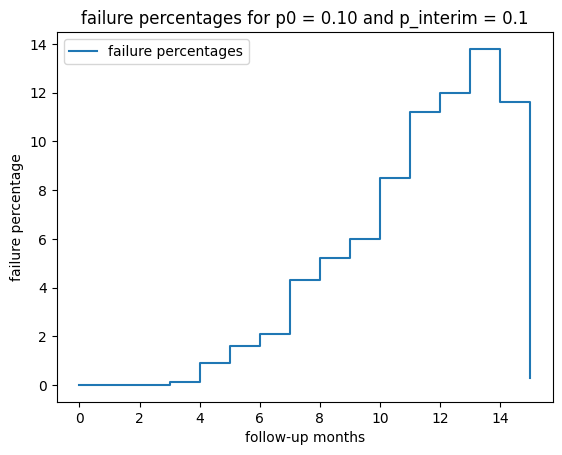

In [29]:
# fix p0 and p_interim
number_of_simulations = 1000
stopping_array_looper = np.zeros((number_of_simulations,2))
patients_at_interim = [60,120]
interim_at_60 = np.zeros((number_of_simulations,3))
interim_at_120 = np.zeros((number_of_simulations,3))
p0 = 0.10
p_interim = [0.10,0.10]
failure_percentage = np.zeros(16)
average_considered_patients = np.zeros(16)
for follow_up in range(0,16):
    minimum_follow_up = follow_up
    for i in range(0,number_of_simulations):
        df_looper, month_looper, interim_analyses_looper = recruitement_evaluator_Jan(recruitement_condition= 120, total_number_pat = 120, p0 = p0,interim=patients_at_interim, minimum_follow_up=minimum_follow_up,p_interim = p_interim)
        interim_at_60[i] = interim_analyses_looper[0]
        interim_at_120[i] = interim_analyses_looper[1]
    failure_percentage[follow_up] = interim_at_60[:,[1]].sum()/number_of_simulations*100
    average_considered_patients[follow_up] = interim_at_60[:,[-1]].mean()

plt.step(range(0,16), failure_percentage, label='failure percentages',where = 'post')
plt.xlabel('follow-up months')
plt.ylabel('failure percentage')
plt.title('failure percentages for p0 = 0.10 and p_interim = 0.1')
plt.legend()

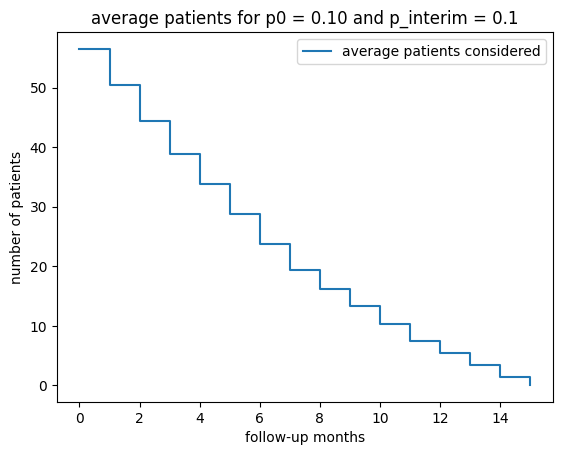

In [30]:
plt.step(range(0,16), average_considered_patients, label='average patients considered',where = 'post')
plt.xlabel('follow-up months')
plt.ylabel('number of patients')
plt.title('average patients for p0 = 0.10 and p_interim = 0.1')
plt.legend()

In [31]:
# fix p0 and follow up
number_of_simulations = 2000
stopping_array_looper = np.zeros((number_of_simulations,2))
patients_at_interim = [60,120]
interim_at_60 = np.zeros((number_of_simulations,3))
interim_at_120 = np.zeros((number_of_simulations,3))
p0 = 0.20
minimum_follow_up = 6
interim_probs = [0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20]
failure_percentage = np.zeros(11)
average_considered_patients = np.zeros(11)
for index,p_interim in enumerate(interim_probs):
    for i in range(0,number_of_simulations):
        df_looper, month_looper, interim_analyses_looper = recruitement_evaluator_Jan(recruitement_condition= 120, total_number_pat = 120, p0 = p0,interim=patients_at_interim, minimum_follow_up=minimum_follow_up,p_interim = p_interim)
        interim_at_60[i] = interim_analyses_looper[0]
        interim_at_120[i] = interim_analyses_looper[1]
    failure_percentage[index] = interim_at_60[:,[1]].sum()/number_of_simulations*100

plt.step(interim_probs, failure_percentage, label='failure percentage',where = 'post')
plt.xlabel('interim p-value')
plt.ylabel('failure percentage')
plt.title('failure percentages for p0 = 0.20 and follow-up = 6')
plt.legend()


TypeError: 'float' object is not subscriptable

In [ ]:
failure_percentage

array([2.2 , 1.5 , 1.25, 0.3 , 0.55, 0.25, 0.15, 0.1 , 0.05, 0.  , 0.  ])

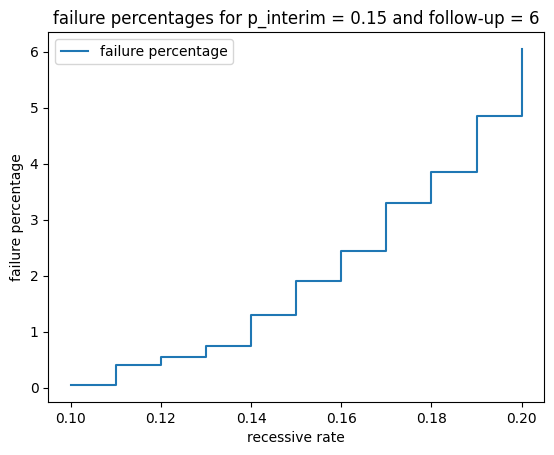

In [32]:
# fix p_interim and follow up
number_of_simulations = 2000
stopping_array_looper = np.zeros((number_of_simulations,2))
patients_at_interim = [60,120]
interim_at_60 = np.zeros((number_of_simulations,3))
interim_at_120 = np.zeros((number_of_simulations,3))
p_interim = [0.15,0.15]
minimum_follow_up = 6
p0_probs = [0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20]
failure_percentage = np.zeros(11)
average_considered_patients = np.zeros(11)
for index,p0 in enumerate(p0_probs):
    for i in range(0,number_of_simulations):
        df_looper, month_looper, interim_analyses_looper = recruitement_evaluator_Jan(recruitement_condition= 120, total_number_pat = 120, p0 = p0,interim=patients_at_interim, minimum_follow_up=minimum_follow_up,p_interim = p_interim)
        interim_at_60[i] = interim_analyses_looper[0]
        interim_at_120[i] = interim_analyses_looper[1]
    failure_percentage[index] = interim_at_60[:,[1]].sum()/number_of_simulations*100

plt.step(p0_probs, failure_percentage, label='failure percentage',where = 'post')
plt.xlabel('recessive rate')
plt.ylabel('failure percentage')
plt.title('failure percentages for p_interim = 0.15 and follow-up = 6')
plt.legend()


Here visualize how the different cut off values for different number of recruited patients do not always give 5% failure but are higher first and stabilize for more patients

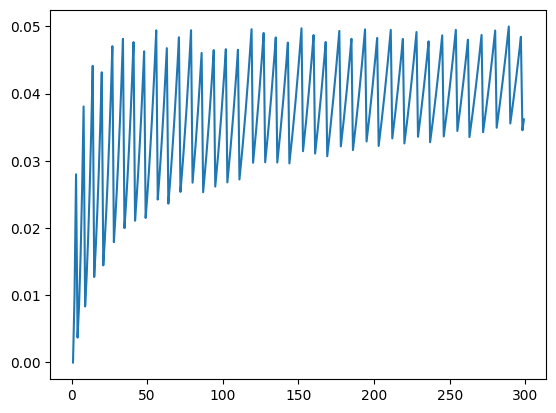

In [ ]:
x = list(range(1,300))
y = []
for i in x:
    cut_off = binom.ppf(0.95, i, 0.10)
    y.append(1 - binom.cdf(cut_off, i, 0.10))
plt.plot(x,y)
plt.xlabel('number of patients')
plt.ylabel('p-value')
plt.title('')

In [ ]:
1-binom.cdf(38, i, 0.10)

0.052703447093348066

## Recruitement process visualization

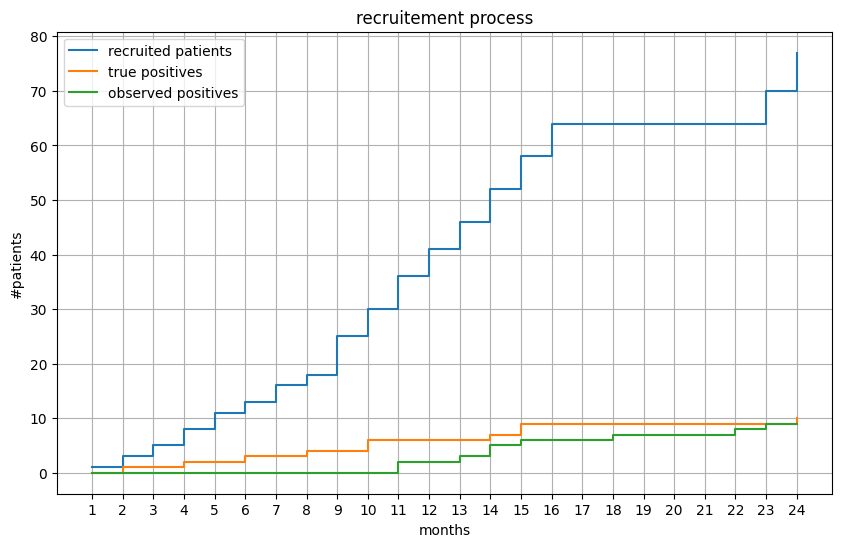

In [139]:
month = 24
running_months = month


def com_sum_creator(df,column):
    numbers_per_month = []
    for month_of_rec in range(1,month+1):
        numbers_per_month.append(df[column].loc[(df['Month of recruitement'] == month_of_rec)].sum())

    cumulative_patients = []
    current_sum = 0

    # Iterate over the list and compute the cumulative sum
    for value in numbers_per_month:
        current_sum += value
        cumulative_patients.append(current_sum)
    return cumulative_patients


recruited_patients_per_month = []
for month_of_rec in range(1,month+1):
    recruited_patients_per_month.append((df['Month of recruitement'] == month_of_rec).sum())

cumulative_patients = []
current_sum = 0

# Iterate over the list and compute the cumulative sum
for value in recruited_patients_per_month:
    current_sum += value
    cumulative_patients.append(current_sum)

cumulative_positive = com_sum_creator(df,'True recessive status')

observed = np.zeros(running_months)
cumulative_observed = []
diagnose_time = df.loc[df['True recessive status'] == 1]['Month of recruitement'] + df.loc[df['True recessive status'] == 1]['diagnose time after treatment']
for i in range(1,running_months + 1):
    observed[i-1] = (diagnose_time == i).sum()

current_sum = 0
for value in observed:
    current_sum += value
    cumulative_observed.append(current_sum)

plt.figure(figsize = (10,6))
plt.step(list(range(1,running_months + 1)), cumulative_patients, label='recruited patients',where = 'post')
plt.step(list(range(1,running_months + 1)), cumulative_positive, label='true positives',where = 'post')
plt.step(list(range(1,running_months + 1)), cumulative_observed, label='observed positives',where = 'post')
plt.grid(visible = True)
plt.xlabel('months')
plt.ylabel('#patients')
plt.xticks(range(1,running_months + 1))
plt.title('recruitement process')
plt.legend()



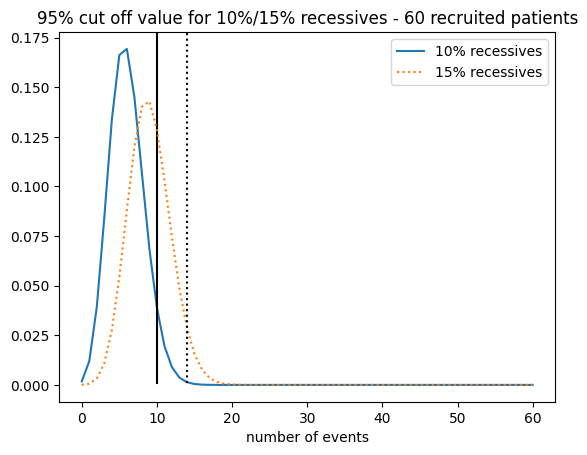

In [ ]:
cut_off = binom.ppf(0.95, 60, 0.10)
plt.plot(range(0,61),binom.pmf(range(0,61),60,0.1),label = '10% recessives')
plt.axvline(cut_off,ymin = 0.05, color = 'k')
plt.plot(range(0,61),binom.pmf(range(0,61),60,0.15),linestyle = 'dotted', label = '15% recessives')
cut_off = binom.ppf(0.95, 60, 0.15)
plt.axvline(cut_off,ymin = 0.05, color = 'k', linestyle = 'dotted')
plt.xlabel('number of events')
plt.title('95% cut off value for 10%/15% recessives - 60 recruited patients')
plt.legend()